In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import utils as ut
import m_models as mm
import os
from tqdm import tqdm_notebook as tqdm

import pylab

import statsmodels.api as sm

import scipy.stats as sps
from scipy.optimize import minimize_scalar as minimize_scalar

import pickle

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']= 36
plt.rcParams['axes.labelsize']= 40
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [48]:
name = 'diabetes'

In [49]:
X, y = ut.DataLoader(name=name)
X, y = ut.preprocess(X, y)

In [57]:
real_data = mm.ALC(X, y, progress_bar=lambda x: tqdm(x, leave = False))

In [58]:
statmodel = ut.define_model(y)

In [59]:
sample_size = np.arange(10, 500, 5)
print(X.shape)

(442, 5)


In [60]:
def aDistribution(cov, alpha=0.05):
    
    W = sps.multivariate_normal(mean=np.zeros(cov.shape[0]), cov = cov).rvs(size=1000)

    function = lambda r: (((W ** 2).sum(axis=1) > r ** 2).mean() - alpha) ** 2

    res = minimize_scalar(function, method='Golden')['x']
    return res

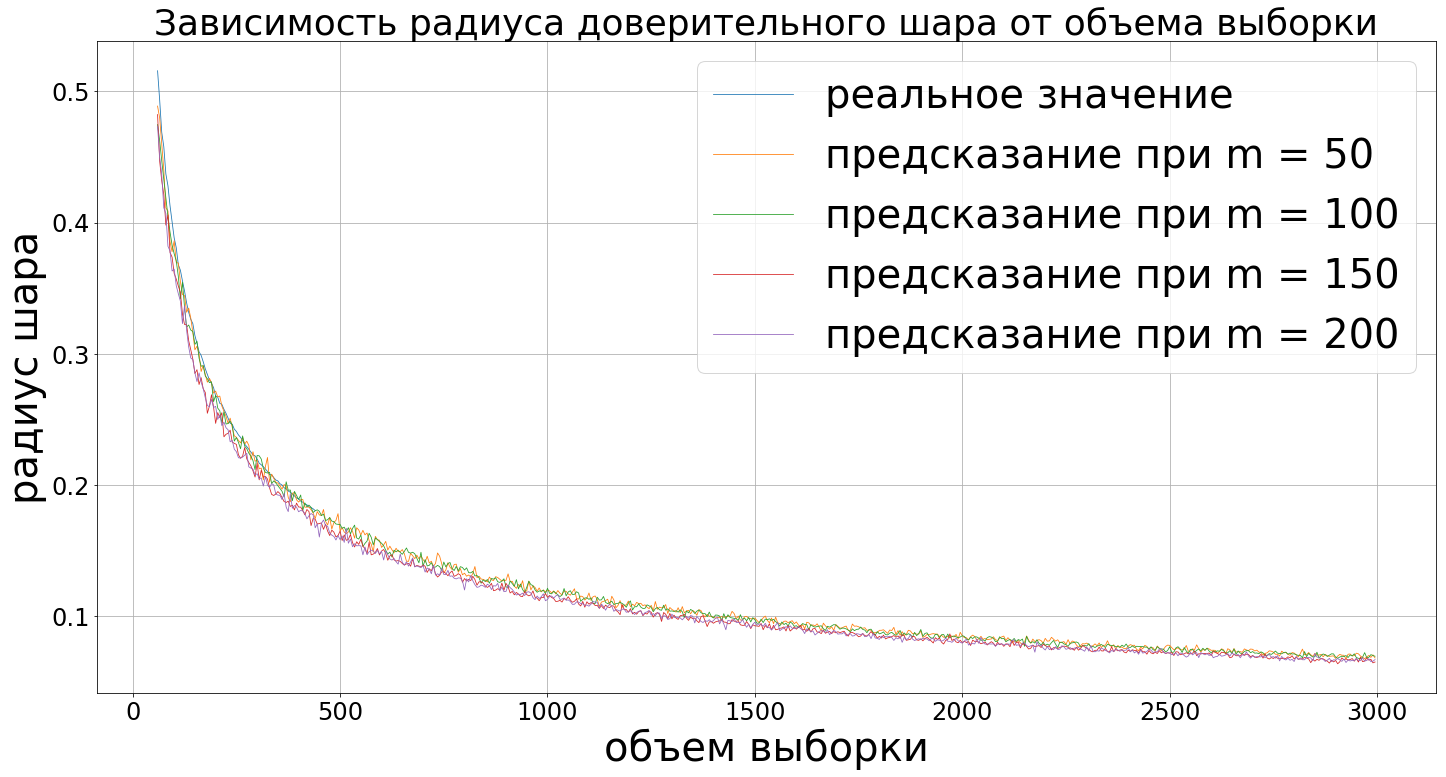

In [61]:
num_iters = 1000

r = 10

sample_sizes = np.arange(10, 3000, 5)  

plt.plot(real_data['m'][r:], real_data['E'][r:], lw = 0.8, label='реальное значение')
plt.title('Зависимость радиуса доверительного шара от объема выборки')

for m in [50, 100, 150, 200]:
    
    X_m, y_m = ut.get_subset(X, y, m, duplications=False)
    w_hat = ut.get_params(X_m, y_m)
    
    answers = []
    
    for i in tqdm(range(num_iters)):
        X_sub, y_sub = ut.get_subset(X_m, y_m, m // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))
    
    answers = np.asarray(answers)
    
    i_matrix = np.linalg.inv(np.mean(answers, axis = 0))
      
    rs = []

    for cur_m in tqdm(sample_sizes):
        rs.append(aDistribution(i_matrix / cur_m))
    
    rs = np.asarray(rs)
    
    plt.plot(sample_sizes[r:], rs[r:], lw = 0.8, label='предсказание при m = {}'.format(m))

plt.xlabel('объем выборки')
plt.ylabel('радиус шара')
plt.grid()
plt.legend()
plt.show()

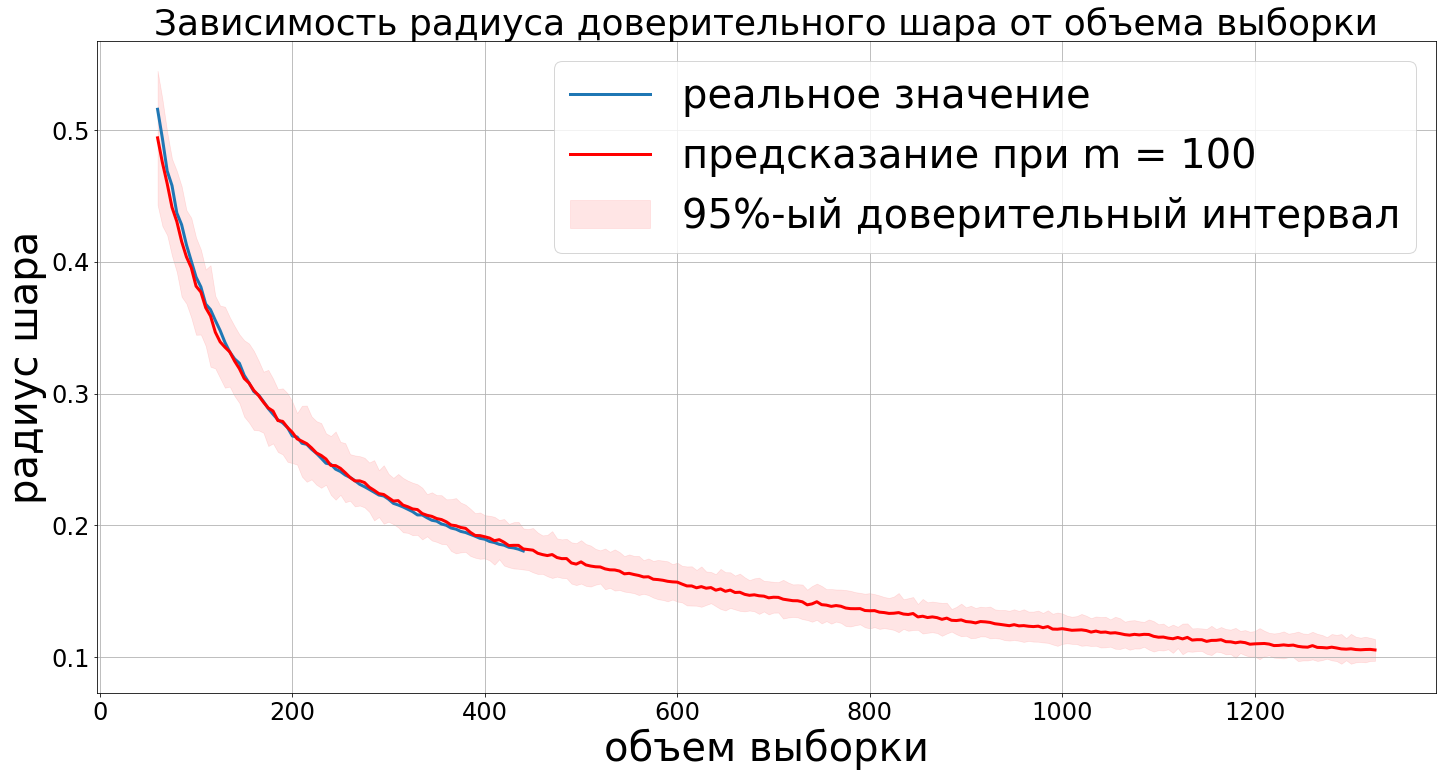

In [62]:
m = 100
r = 10

sample_sizes = np.arange(10, 3 * X.shape[0], 5)  

many_rs = []

plt.plot(real_data['m'][r:], real_data['E'][r:], label='реальное значение')
plt.title('Зависимость радиуса доверительного шара от объема выборки')

for i in range(20):
    
    X_m, y_m = ut.get_subset(X, y, m, duplications=False)
    w_hat = ut.get_params(X_m, y_m)
    
    answers = []
    
    for i in range(num_iters):
        X_sub, y_sub = ut.get_subset(X_m, y_m, m // 2, duplications=False)
        model = statmodel(y_sub, X_sub)
        w_hat = ut.get_params(X_sub, y_sub)
        answers.append((-model.hessian_fixed(w_hat) / X_sub.shape[0]))
    
    answers = np.asarray(answers)
    
    i_matrix = np.linalg.inv(np.mean(answers, axis = 0))
    
    rs = []

    for cur_m in sample_sizes:
        rs.append(aDistribution(i_matrix / cur_m))
    
    rs = np.asarray(rs)
    many_rs.append(rs)

many_rs = np.asarray(many_rs)

alpha = 0.95

left_q = sps.norm(loc=many_rs.mean(axis=0)[r:], scale=many_rs.std(axis=0)[r:]).ppf((1 - alpha) / 2)
right_q = sps.norm(loc=many_rs.mean(axis=0)[r:], scale=many_rs.std(axis=0)[r:]).ppf(1 - (1 - alpha) / 2)

plt.plot(sample_sizes[r:], many_rs.mean(axis=0)[r:], color='red', label='предсказание при m = {}'.format(m))
plt.fill_between(sample_sizes[r:], left_q,right_q, 
                 color='red', lw=0.7, alpha=0.1, label='95%-ый доверительный интервал')

plt.xlabel('объем выборки')
plt.ylabel('радиус шара')
plt.legend()
plt.grid()
plt.savefig('../data/pics/ALC_modified_{}.pdf'.format(name), format='pdf')
plt.show()